<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Langgraph/module-1/3_Router.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Router
## Review

We built a graph that uses messages as state and a chat model with bound tools.

We saw that the graph can:

- Return a tool call
- Return a natural language response

## Goals
We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is an simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly.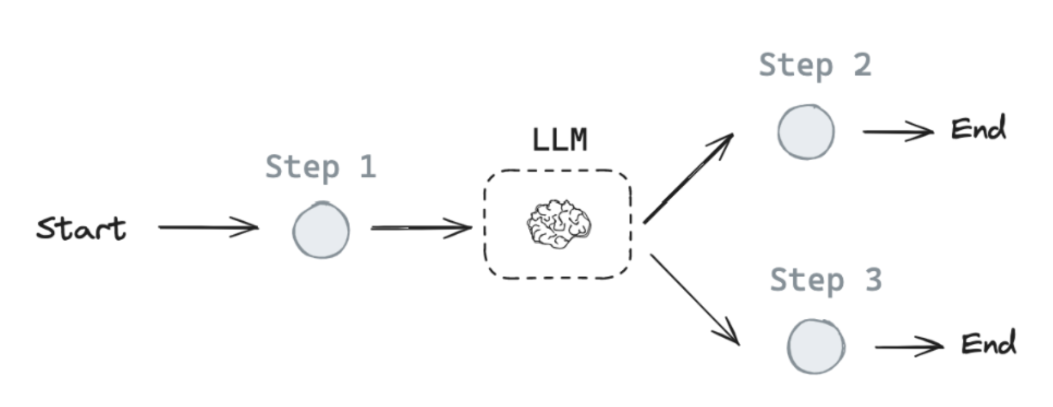

Let's extend our graph to work with either output!

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [2]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)
llm_with_tools = llm.bind_tools([multiply])

## AI agent architectures
The introduction of `ToolNode` and `tool_condition` in LangGraph represents a significant advancement in AI agent architectures. These components enhance the framework's flexibility and capability in several ways:

**1. Simplified Tool Integration**

With ToolNode, developers can seamlessly incorporate a variety of tools into their AI agents by passing a list of tools during initialization. This streamlined process reduces complexity and accelerates development.

**2. Conditional Execution with tool_condition**

The tool_condition feature allows for dynamic decision-making within the agent's workflow. Agents can evaluate conditions at runtime and choose appropriate actions, enabling more responsive and intelligent behavior.

**3. Enhanced Support for Diverse Architectures**

These features facilitate the implementation of various AI agent architectures, including:

- **ReAct Architecture:** Integrates reasoning and action by allowing agents to decide when to invoke tools based on current context.
- **DEPS (Describe, Explain, Plan, Select)**: Supports structured decision-making processes by enabling conditional tool usage.
- **Reflexion Architecture:** Allows agents to reflect on actions and outcomes, adjusting behavior dynamically.
- **Talker-Reasoner Architecture:** Separates communication and reasoning processes, with conditional tool invocation enhancing reasoning capabilities.
- **Cognitive Architectures (e.g., Soar)**: Supports complex, human-like reasoning and decision-making processes through dynamic tool integration.

By providing these capabilities, LangGraph's `ToolNode` and `tool_condition` contribute to the evolution of agentic AI, moving beyond static models to more adaptive and intelligent systems. This progression aligns with the broader trend of enhancing AI agents' reasoning and decision-making abilities, marking a pivotal step in the development of advanced AI architectures.

**AI Agent architecture:** https://chatgpt.com/share/67362fc6-aed8-8004-9bcd-40a1f92b184e

**Note:** Warning indicates that the title key is being generated internally, likely within LangGraph or the Gemini integration when the tool is being bound, rather than being passed explicitly. So ignore the warning.

We use the built-in ToolNode and simply pass a list of our tools to initialize it.

We use the built-in tools_condition as our conditional edge.

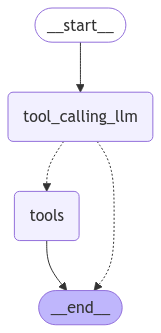

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.state import CompiledStateGraph

# Node
def tool_calling_llm(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
messages = [SystemMessage(content="") , HumanMessage(content="What is a product of 2 and 3")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


================================ Human Message =================================

What is a product of 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (b91226d2-7478-4aa2-b90a-87f34df9f283)
 Call ID: b91226d2-7478-4aa2-b90a-87f34df9f283
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6


In [6]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Multiply 6 and 5.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 6 and 5.
================================== Ai Message ==================================
Tool Calls:
  multiply (f45924c5-5221-4da2-924c-e6415c78c80c)
 Call ID: f45924c5-5221-4da2-924c-e6415c78c80c
  Args:
    a: 6.0
    b: 5.0
================================= Tool Message =================================
Name: multiply

30


## LangGraph Studio

--

⚠️ DISCLAIMER

Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.
--
Load the router in Studio, which uses module-1/studio/router.py set in module-1/studio/langgraph.json
